# Introduction to Weighted Ensemble Data Analysis in wepy
Samuel Lotz

Dickson Lab Group Meeting

2018-08-22

In [5]:
import os
import os.path as osp
import random as rand

import warnings
warnings.filterwarnings("ignore")

rand.seed(33)

from PIL import Image

prez_dir = osp.expanduser("~/tree/lab/studio/projects/index/presentation.DicksonGroupMeeting_2018-08-22")
example_dir = osp.join(prez_dir, "Lennard_Jones_Pair")
media_dir = osp.join(prez_dir, "media")
outputs_dir = osp.join(example_dir, "outputs")

# make the outputs dir if it doesn't exist
os.makedirs(outputs_dir, exist_ok=True)

# remove all files in the outputs dir
for f in os.listdir(outputs_dir):
    print("removing outputs/{}".format(f))
    os.remove(osp.join(outputs_dir, f))


# paths for all of the results
wepy1_path = osp.join(outputs_dir, 'results_run1.wepy.h5')
wepy2_path = osp.join(outputs_dir, 'results_run2.wepy.h5')
wepy3_path = osp.join(outputs_dir, 'results_run2_cont3.wepy.h5')


def rescale(image, factor):
    new_shape = [int(dim * factor) for dim in image.size]
    new_image = image.resize(new_shape, Image.ANTIALIAS)
    
    return new_image

# load all the images
CSN_workflow_longway_im = Image.open(osp.join(media_dir, "CSN_workflow_longway.png"))
trad_md_windows_im = Image.open(osp.join(media_dir, "trad_MD_windows.png"))
we_md_windows_im = Image.open(osp.join(media_dir, "we_MD_windows.png"))
continuation_runs_im = Image.open(osp.join(media_dir, "continuation_runs.png"))
contig_tree_im = Image.open(osp.join(media_dir, "contig_tree.png"))
CSN_workflow_shortway_im = Image.open(osp.join(media_dir, "CSN_workflow_shortway.png"))
linking_files_im = Image.open(osp.join(media_dir, "linking_files.png"))

removing outputs/results_run2.wepy.h5
removing outputs/restart_run1_cont1.pkl
removing outputs/restart_run1_cont2.pkl
removing outputs/restart_run2_cont3.pkl
removing outputs/results_run1.wepy.h5
removing outputs/results_run2_cont3.wepy.h5
removing outputs/restart_run1.pkl
removing outputs/restart_run2.pkl


Run the simulation

In [6]:
import sys
from copy import copy, deepcopy
import os
import os.path as osp
import pickle

import numpy as np
from scipy.spatial.distance import euclidean

import simtk.openmm.app as omma
import simtk.openmm as omm
import simtk.unit as unit

from openmmtools.testsystems import LennardJonesPair
import mdtraj as mdj
from wepy.util.mdtraj import mdtraj_to_json_topology

from wepy.sim_manager import Manager

from wepy.resampling.distances.distance import Distance
from wepy.resampling.resamplers.wexplore import WExploreResampler
from wepy.walker import Walker
from wepy.runners.openmm import OpenMMRunner, OpenMMState
from wepy.runners.openmm import UNIT_NAMES, GET_STATE_KWARG_DEFAULTS
from wepy.work_mapper.mapper import Mapper
from wepy.boundary_conditions.unbinding import UnbindingBC
from wepy.reporter.hdf5 import WepyHDF5Reporter
from wepy.reporter.dashboard import WExploreDashboardReporter
from wepy.reporter.setup import SetupReporter
from wepy.reporter.restart import RestartReporter

from wepy.hdf5 import WepyHDF5



## PARAMETERS

# Platform used for OpenMM which uses different hardware computation
# kernels. Options are: Reference, CPU, OpenCL, CUDA.

# we use the Reference platform because this is just a test
PLATFORM = 'Reference'

# Langevin Integrator
TEMPERATURE= 300.0*unit.kelvin
FRICTION_COEFFICIENT = 1/unit.picosecond
# step size of time integrations
STEP_SIZE = 0.002*unit.picoseconds

# Resampler parameters

# the maximum weight allowed for a walker
PMAX = 0.5
# the minimum weight allowed for a walker
PMIN = 1e-12

# the maximum number of regions allowed under each parent region
MAX_N_REGIONS = (10, 10, 10, 10)

# the maximum size of regions, new regions will be created if a walker
# is beyond this distance from each voronoi image unless there is an
# already maximal number of regions
MAX_REGION_SIZES = (1, 0.5, .35, .25) # nanometers

# boundary condition parameters

# maximum distance between between any atom of the ligand and any
# other atom of the protein, if the shortest such atom-atom distance
# is larger than this the ligand will be considered unbound and
# restarted in the initial state
CUTOFF_DISTANCE = 1.0 # nm

# reporting parameters

# these are the properties of the states (i.e. from OpenMM) which will
# be saved into the HDF5
SAVE_FIELDS = ('positions', 'box_vectors', 'velocities')
# these are the names of the units which will be stored with each
# field in the HDF5
UNITS = UNIT_NAMES

## INPUTS/OUTPUTS


# outputs
hdf5_filename = 'results.wepy.h5'
setup_state_filename = 'setup.pkl'
restart_state_filename = 'restart.pkl'

# normalize the output paths
hdf5_path = osp.join(outputs_dir, hdf5_filename)
setup_state_path = osp.join(outputs_dir, setup_state_filename)
restart_state_path = osp.join(outputs_dir, restart_state_filename)

## System and OpenMMRunner

# make the test system from openmmtools
test_sys = LennardJonesPair()

# make the integrator
integrator = omm.LangevinIntegrator(TEMPERATURE, FRICTION_COEFFICIENT, STEP_SIZE)

# make a context and set the positions
context = omm.Context(test_sys.system, copy(integrator))
context.setPositions(test_sys.positions)

# get the data from this context so we have a state to start the
# simulation with
get_state_kwargs = dict(GET_STATE_KWARG_DEFAULTS)
init_sim_state = context.getState(**get_state_kwargs)
init_state = OpenMMState(init_sim_state)

# initialize the runner
runner = OpenMMRunner(test_sys.system, test_sys.topology, integrator, platform=PLATFORM)

## Distance Metric
# we define a simple distance metric for this system, assuming the
# positions are in a 'positions' field
class PairDistance(Distance):

    def __init__(self, metric=euclidean):
        self.metric = metric

    def image(self, state):
        return state['positions']

    def image_distance(self, image_a, image_b):
        dist_a = self.metric(image_a[0], image_a[1])
        dist_b = self.metric(image_b[0], image_b[1])

        return np.abs(dist_a - dist_b)


# make a distance object which can be used to compute the distance
# between two walkers, for our scorer class
distance = PairDistance()

## Resampler
resampler = WExploreResampler(distance=distance,
                               init_state=init_state,
                               max_region_sizes=MAX_REGION_SIZES,
                               max_n_regions=MAX_N_REGIONS,
                               pmin=PMIN, pmax=PMAX)

## Boundary Conditions

# the mdtraj here is needed for the distance function
mdtraj_topology = mdj.Topology.from_openmm(test_sys.topology)

# initialize the unbinding boundary conditions
ubc = UnbindingBC(cutoff_distance=CUTOFF_DISTANCE,
                  initial_state=init_state,
                  topology=mdtraj_topology,
                  ligand_idxs=np.array(test_sys.ligand_indices),
                  receptor_idxs=np.array(test_sys.receptor_indices))

## Reporters

json_str_top = mdtraj_to_json_topology(mdtraj_topology)
# make a dictionary of units for adding to the HDF5
units = dict(UNIT_NAMES)

# open it in truncate mode first, then switch after first run
hdf5_reporter = WepyHDF5Reporter(hdf5_path, mode='w',
                                 save_fields=SAVE_FIELDS,
                                 resampler=resampler,
                                 boundary_conditions=ubc,
                                 topology=json_str_top,
                                 units=units,)

restart_reporter = RestartReporter(restart_state_path, mode='w')

## Work Mapper

# a simple work mapper
mapper = Mapper()

## initial walkers
n_walkers = 4
init_weight = 1.0 / n_walkers
init_walkers = [Walker(OpenMMState(init_sim_state), init_weight) for i in range(n_walkers)]

## run parameters
n_cycles = 100
n_steps = 1000
# steps for each cycle
steps = [n_steps for i in range(n_cycles)]

## filenames
hdf5_template = "results_{}.wepy.h5"
restart_template = 'restart_{}.pkl'

## to use these from here we should be careful to make copies of them
## and to change paths if needed


# paths for run1 reporters
run1_str = "run1"
run1_hdf5_path = osp.join(outputs_dir, hdf5_template.format(run1_str))
run1_restart_path = osp.join(outputs_dir, restart_template.format(run1_str))
# WepyHDF5 reporter
run1_hdf5_reporter = deepcopy(hdf5_reporter)
run1_hdf5_reporter.file_path = run1_hdf5_path
# restart reporter
run1_restart_reporter = deepcopy(restart_reporter)
run1_restart_reporter.file_path = run1_restart_path

reporters_1 = [run1_hdf5_reporter, run1_restart_reporter]

# run two simulations from the initial conditions
sim_manager_1 = Manager(deepcopy(init_walkers),
                        runner=deepcopy(runner),
                        resampler=deepcopy(resampler),
                        boundary_conditions=deepcopy(ubc),
                        work_mapper=deepcopy(mapper),
                        reporters=reporters_1
                    )
sim_manager_1.run_simulation(n_cycles, steps)
print("run 0 in file 1")

# paths for run2 reporters
run2_str = "run2"
run2_hdf5_path = osp.join(outputs_dir, hdf5_template.format(run2_str))
run2_restart_path = osp.join(outputs_dir, restart_template.format(run2_str))
# WepyHDF5 reporter
run2_hdf5_reporter = deepcopy(hdf5_reporter)
run2_hdf5_reporter.file_path = run2_hdf5_path
# restart reporter
run2_restart_reporter = deepcopy(restart_reporter)
run2_restart_reporter.file_path = run2_restart_path

reporters_2 = [run2_hdf5_reporter, run2_restart_reporter]

sim_manager_2 = Manager(deepcopy(init_walkers),
                        runner=deepcopy(runner),
                        resampler=deepcopy(resampler),
                        boundary_conditions=deepcopy(ubc),
                        work_mapper=deepcopy(mapper),
                        reporters=reporters_2
                    )

sim_manager_2.run_simulation(n_cycles, steps)
print("run 0 in file 2")


# we run a restart of run1 in the first file
with open(run1_restart_path, 'rb') as rf:
    restarter = pickle.load(rf)

cont1_run = 0
# make the restarted sim manager with the suffix
cont1_sim_manager = restarter.new_sim_manager(file_report_suffix="_cont1")
# we want to run this in the same HDF5 file as run1
cont1_sim_manager.reporters[0].file_path = run1_hdf5_path
cont1_sim_manager.reporters[0].mode = "r+"

cont1_sim_manager.continue_run_simulation(cont1_run, n_cycles, steps)
print("run 1 in file 0 continues run 0 in file 0".format(cont1_run))

# run another continuation from run1
cont2_sim_manager = restarter.new_sim_manager(file_report_suffix="_cont2")
# we want to run this in the same HDF5 file as run1
cont2_sim_manager.reporters[0].file_path = run1_hdf5_path
cont2_sim_manager.reporters[0].mode = "r+"

cont2_sim_manager.continue_run_simulation(cont1_run, n_cycles, steps)
print("run 2 in file 0 continues run 0 in file 0")


# then we run a restart of run2 in another file
with open(run2_restart_path, 'rb') as rf:
    restarter = pickle.load(rf)

cont3_run = 1
# make the restarted sim manager with the suffix
cont3_sim_manager = restarter.new_sim_manager(file_report_suffix="_cont3")

# we don't run this as a continue because it is in a different file
cont3_sim_manager.run_simulation(n_cycles, steps)

print("run 0 in file 3 continues run 0 in file 2")



single
run 0 in file 1
run 0 in file 2
run 1 in file 0 continues run 0 in file 0
run 2 in file 0 continues run 0 in file 0
run 0 in file 3 continues run 0 in file 2


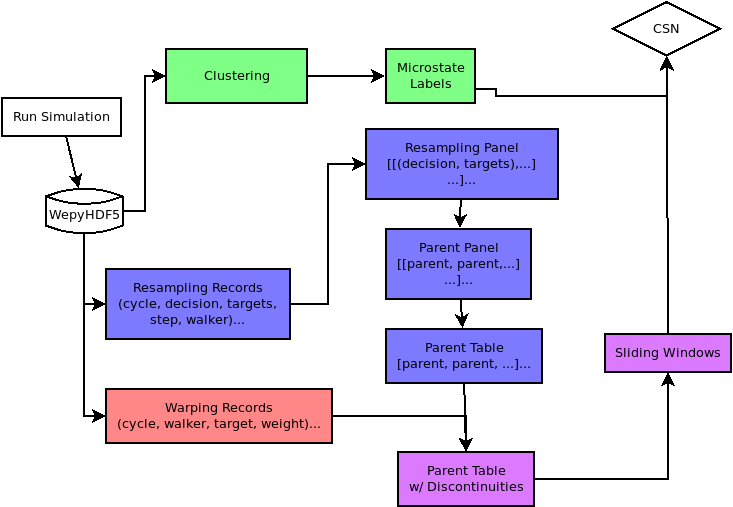

In [7]:
rescale(CSN_workflow_longway_im, 1.0)

### Load Dataset and Generate Fake Clusters

In [8]:
import numpy as np

from wepy.hdf5 import WepyHDF5

wepy1 = WepyHDF5(wepy1_path, mode='r+')
wepy1.open()

run_idx = 0
assg_key = 'rand_assg_idx'
n_classifications = 50

# observable function, fictituous random "cluster" assignments
def rand_assg(fields_d, *args, **kwargs):
    assignments = np.random.random_integers(0, n_classifications,
                                     size=fields_d['weights'].shape[0])
    return assignments

# compute this random assignment "observable"
wepy1.compute_observable(rand_assg, ['weights'],
                           save_to_hdf5=assg_key, return_results=False)


### Sliding Windows Workflow

In [9]:
import numpy as np
from wepy.hdf5 import WepyHDF5
from wepy.resampling.decisions.clone_merge import MultiCloneMergeDecision
from wepy.boundary_conditions.unbinding import UnbindingBC
# Analysis modules
from wepy.analysis.transitions import run_transition_probability_matrix
from wepy.analysis.parents import parent_panel, net_parent_table, parent_table_discontinuities
from wepy.analysis.parents import sliding_window

# make a parent matrix from the hdf5 resampling records
resampling_panel = wepy1.run_resampling_panel(run_idx)
parent_panel = parent_panel(MultiCloneMergeDecision, resampling_panel)
parent_table = net_parent_table(parent_panel)

# take into account warping events as discontinuities in the lineage
parent_matrix = parent_table_discontinuities(UnbindingBC, parent_table, wepy1.warping_records([0]))

In [10]:
# use the parent matrix to generate the sliding windows
window_length = 10
windows = list(sliding_window(np.array(parent_matrix), window_length))

# make the transition matrix from the windows
transprob_mat = run_transition_probability_matrix(wepy1, run_idx,
                                                  "observables/{}".format(assg_key), windows)

print(transprob_mat)

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0.5]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


### Lagged Transitions in traditional linear MD

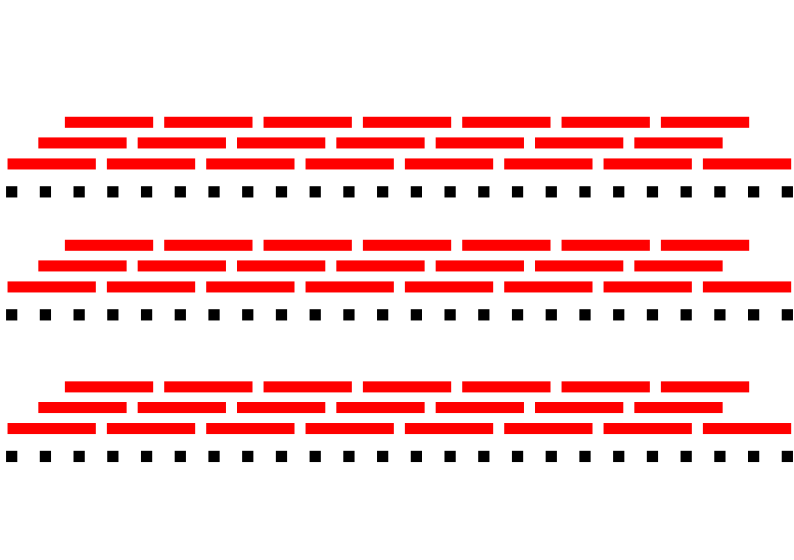

In [7]:
rescale(trad_md_windows_im, 1.0)

### Sliding Windows Algorithm

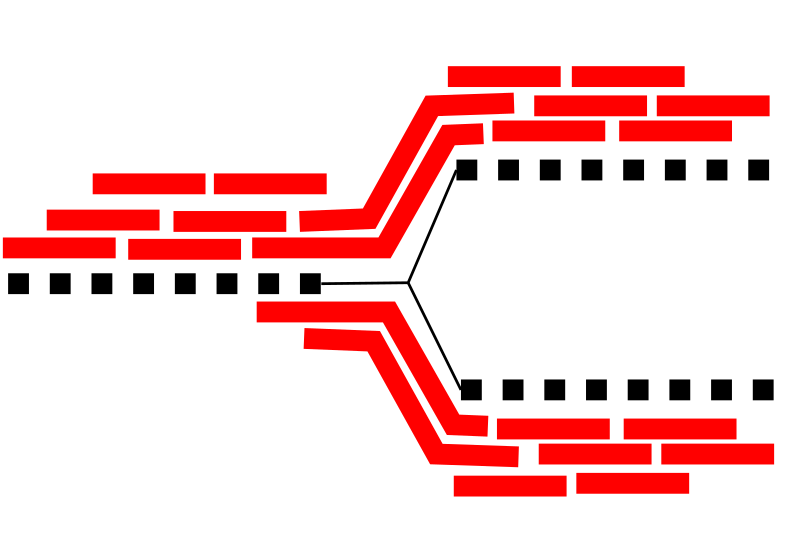

In [8]:
we_md_windows_im

### Multi-Run Data Analysis
So far we have assumed nice contiguous data. This is not so with MD data in general which may be split up into different runs.

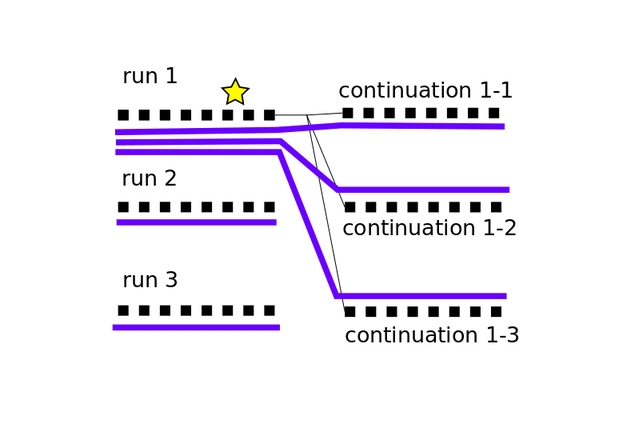

In [9]:
rescale(continuation_runs_im, 0.8)

We want to be able to get transitions between the original run and all of its continuations without double counting.

### Contig Tree
The contig tree is a tree (technically forest) of continuous simulations. For us the branchings happen when a run is continued multiple times.

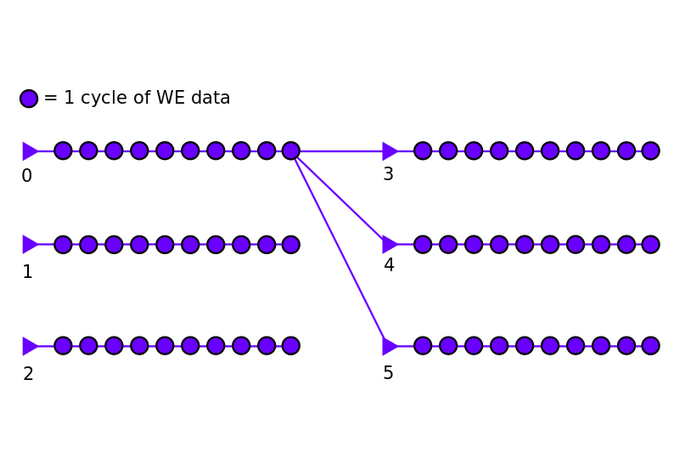

In [10]:
rescale(contig_tree_im, 0.85)

The Spanning Contigs are the contigs drawn before: (0,3) (0,4) (0,5) (1,) (2,)

### Storage Implementation: Continuations

The only thing that must exist is a specification of the continuations that exist in a `WepyHDF5` file.

In [11]:
print("Runs in this file:", wepy1.run_idxs)
print("Continuations using the API method:\n", wepy1.continuations)
print("Where it is actually stored in the HDF5:\n", wepy1.h5['_settings/continuations'][:])

Runs in this file: [0, 1, 2]
Continuations using the API method:
 [[1 0]
 [2 0]]
Where it is actually stored in the HDF5:
 [[1 0]
 [2 0]]


Run 1 continues run 0, and run 2 continues run 0.

This only works within a single file (but we can do interfile linking).

### API for interacting with continuations: Contigs

A contig is a list of runs that form a contiguous dataset.

For the continuation (1,0) the contig is (0,1).

Contigs can be any number of runs.

In [18]:
print("Contig {} has {} frames".format([0], wepy1.contig_n_cycles([0])))
print("Contig {} has {} frames".format([1], wepy1.contig_n_cycles([1])))
print("Contig {} has {} frames".format([2], wepy1.contig_n_cycles([2])))
print("Contig {} has {} frames".format([0,1], wepy1.contig_n_cycles([0,1])))
print("Contig {} has {} frames".format([0,2], wepy1.contig_n_cycles([0,2])))
#wepy1.resampling_records_dataframe([0,1])

Contig [0] has 100 frames
Contig [1] has 100 frames
Contig [2] has 100 frames
Contig [0, 1] has 200 frames
Contig [0, 2] has 200 frames


A *spanning contig* is a contig which goes from a root run (a run that does not continue another run) and a leaf run (a run which is not continued). These can be enumerated:

In [13]:
spanning_contigs = wepy1.spanning_contigs()
print("The spanning contigs:", spanning_contigs)

The spanning contigs: [[0, 1], [0, 2]]


#### The Contig Tree Class

In [20]:
from wepy.analysis.contig_tree import ContigTree
contig_tree = ContigTree(wepy1, decision_class=MultiCloneMergeDecision,
                         boundary_condition_class=UnbindingBC,
                        )

Since we have given it everything it needs to make the parent table from the previous example it can automate it all with the appropriate sliding windows algorithms for multiple runs!

In [15]:
contig_tree.sliding_windows(3)[-5:-1]

[[(0, 3, 1), (0, 3, 2), (0, 3, 3)],
 [(0, 2, 0), (0, 0, 1), (0, 0, 2)],
 [(0, 1, 0), (0, 1, 1), (0, 1, 2)],
 [(0, 2, 0), (0, 2, 1), (0, 2, 2)]]

### The Macro-State Network Class

In order to make a Conformation State Network (CSN) we need to have the transitions (end-points of sliding windows) and the labels of the micro-states (frames of simulations) which can be from clustering or whatever else.

Because, a ContigTree can in the most degenerate form be a single run it is the most appropriate inputs for a general macro-state network.

In [22]:
from wepy.analysis.network import MacroStateNetwork

random_state_net = MacroStateNetwork(contig_tree, transition_lag_time=3,
                                     assg_field_key="observables/rand_assg_idx")

Because this object directly wraps the WepyHDF5 file, we have access to all the data including weights, positions, box sizes etc. and so we can perform all kinds of fancy operations on a macrostate basis.


### Weights/Free Energy of the Macrostates

Since we are principally interested in the free energy of macrostates the weights of the macrostates are a canonical example. 

In [23]:
# compute the weights of the macrostates and set them as node attributes
random_state_net.set_nodes_field('Weight', random_state_net.macrostate_weights())

# get the weight of a node
print(random_state_net.graph.node[39]['Weight'])

3.2531508449465036


### Transition Probabilitiy Matrix

To make an actual network we would need the transition probabilities as well, which were calculated with the lag time given when we created the network.

In [24]:
print(random_state_net.probmat)

[[0.         0.         0.03225806 ... 0.04347826 0.04545455 0.03125   ]
 [0.07692308 0.05555556 0.         ... 0.         0.         0.        ]
 [0.         0.05555556 0.06451613 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.04347826 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.09375   ]
 [0.07692308 0.         0.06451613 ... 0.         0.         0.03125   ]]


### Updated User Workflow

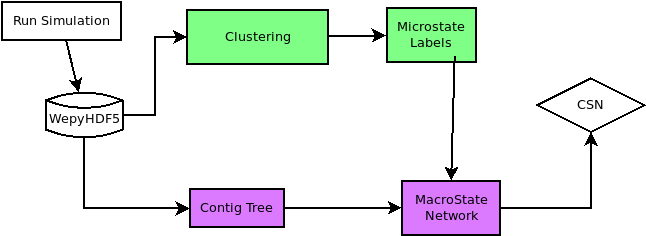

In [19]:
rescale(CSN_workflow_shortway_im, 1.0)

### Synergism with CSNAnalysis

This is the assymetric probability matrix. You can calculate interesting things with it related to paths etc. with the `CSNAnalysis` package from here on.

The purpose of this class is to calculate transition probabilities and create a direct interface to microstates in the HDF5 from a macrostate perspective.

In [25]:
from csnanalysis.csn import CSN
from csnanalysis.matrix import *

csn = CSN(random_state_net.countsmat, symmetrize=True)

### Committor Probabilities

Calculate the distance between the two particles:

In [26]:
from scipy.spatial.distance import euclidean

dists = []
for node_id, field_d in random_state_net.iter_nodes_fields(['positions']).items():
    
    # just use the positions of the first frame in the cluster
    pos_A, pos_B = field_d['positions'][0][0], field_d['positions'][0][1]
    
    dist = euclidean(pos_A, pos_B)
    dists.append(dist)


Determine the source and sink basins and compute the committor probabilities:

In [27]:
    
# the sink basins are those close to the unbinding cutoff
sink_basin = [int(i) for i in np.argwhere(np.array(dists) > 2.5)]
# the source basins are where they are close together
source_basin = [int(i) for i in np.argwhere(np.array(dists) < 0.37)]

print("Number of sink states:", len(sink_basin))
print("Number of source states:", len(source_basin))

committor_probabilities = csn.calc_committors([source_basin, sink_basin])
committor_probabilities[39]

Number of sink states: 2
Number of source states: 3


array([0.5639545, 0.4360455])

### Microstates in the Macrostate

The macrostate keeps track of the microstates by a 'trace' which in `wepy` parlance is just a list of indices into the main wepy HDF5 data structure to a specific microstate, i.e. list of (run index, walker index, cycle index) tuples.



In [28]:
node8_trace = random_state_net.node_assignments(8)
print(node8_trace)

[(0, 0, 32), (0, 0, 56), (0, 0, 65), (0, 1, 13), (0, 1, 18), (0, 1, 43), (0, 1, 71), (0, 1, 73), (0, 1, 97), (0, 2, 22), (0, 2, 69), (0, 3, 44), (1, 0, 32), (1, 0, 57), (1, 0, 59), (1, 1, 28), (1, 2, 45), (1, 2, 68), (1, 2, 76), (1, 3, 37), (1, 3, 61), (2, 0, 39), (2, 0, 45), (2, 1, 16), (2, 2, 81), (2, 3, 41), (2, 3, 46), (2, 3, 65)]


### Visualizing Microstates

This is used to make it very easy to visualize the microstates by allowing export to other trajectory software better supported by viewers like `mdtraj`.

In [29]:
# get an mdtraj trajectory object from the microstates in a node
node8_traj = random_state_net.state_to_mdtraj(8)
node8_traj.superpose(node8_traj)
print("{} frames in macrostate {}".format(node8_traj.n_frames, 8))
import nglview as nv
view = nv.show_mdtraj(node8_traj)
view

28 frames in macrostate 8


NGLWidget(count=28)

### Linking Runs Together

When doing many runs over different jobs and with continuations we found that it would be useful to be able to link them all into a single file and thus not have to worry about different files when doing analysis.

Luckily, the HDF5 standard provides a way to do this and is now incorporated into `wepy.hdf5`.

The main methods we can use to accomplish this are:
- `clone` : copy the header information in a file without run data
-  `add_continuation` : manually specify a continuation within a file
- `link_run` : link a single run from another file, optionally creating a continuation
- `link_file_runs` : link all runs from another file, preserving their internal continuations

#### Example Datasets

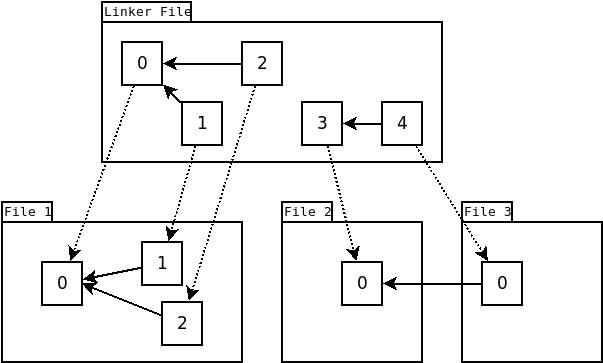

In [21]:
rescale(linking_files_im, 1.0)

In [22]:
wepy2 = WepyHDF5(wepy2_path, mode='r')
wepy3 = WepyHDF5(wepy3_path, mode='r')
with wepy2:
    print("File 2 runs:", wepy2.run_idxs)
with wepy3:
    print("File 3 runs:", wepy3.run_idxs)

File 2 runs: [0]
File 3 runs: [0]


### Code:

In [23]:
# now we are going to link them all under one linker file
linker_h5_path = osp.join(outputs_dir, "all_runs.wepy.h5")
with wepy1:
    all_wepy = wepy1.clone(linker_h5_path, mode='w')

with all_wepy:

    # link the whole file for wepy1 to preserve the continuations
    wepy1_run_idxs = all_wepy.link_file_runs(wepy1_path)

    # do the same for wepy2 just to test it on only one run in a file and
    # because it is easier
    wepy2_run_idxs = all_wepy.link_file_runs(wepy2_path)

    # now we need to link the run from the continuation file for wepy2 and
    # add in the continuation records
    all_wepy.link_run(wepy3_path, 0, continue_run=wepy2_run_idxs[0])
    
    print(all_wepy.spanning_contigs())


[[0, 1], [0, 2], [3, 4]]


In [24]:
all_wepy.open()
wepy1.open()
wepy2.open()
wepy3.open()

### Future Topics

- Automatic exit point ancestry trees and trajectories
- Easier restarts and continuations

#### Requests and Challenges?
- stripping waters
- clustering featurization examples
- linking files with different amount of solvent

#### TODO
- wepy paper
